In this notebook, we take check how transmission looks like if we use two same patterns in one cell.

This should give the same transmission results as using just one copy of the pattern. More bands will show up if we perturb the pattern.

In [2]:
from rcwa4d import *
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

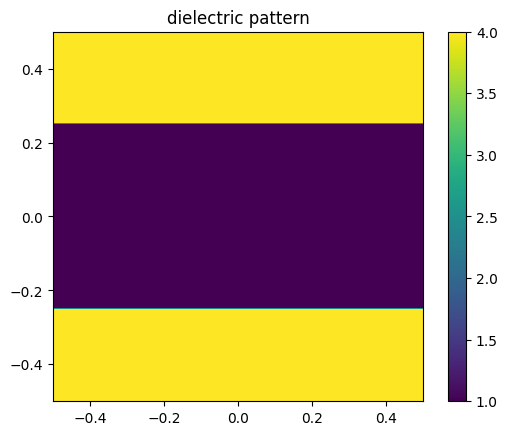

In [3]:
### some params
DEG = np.pi/180
Ny=Nx=1000 ### resolution for dielectric pattern
eps = np.ones([Ny,Nx])*4 ### uniform dielectric slab
radius = 0.25
thickness = 0.2
xs,ys = np.linspace(-0.5,0.5,Nx), np.linspace(-0.5,0.5,Ny)
xs,ys = np.meshgrid(xs,ys)
eps[ys**2 < radius**2] = 1 ### air holes in dielectric slab
plt.imshow(eps,extent=[-0.5,0.5,-0.5,0.5]); 
plt.colorbar(); plt.title('dielectric pattern'); plt.show()
### frequencies to scan through:
freqs = np.linspace(0.51,0.99,101)
thetas = np.linspace(1e-4,89,101) * DEG
inds = range(1,6)

### verifying convention

In [4]:
ind = 1
freq = 0.7
gaps = [0,0.01]

In [5]:
for gap in gaps:
    obj = rcwa([eps,None,eps], [thickness,gap,thickness], [1,1,2], gap_layer_indices=[1], twist=0.1, N=0, M=ind, verbose=0)
    obj.set_freq_k(freq, (0, 0))
    (r,t), (reflected,transmitted) = obj.get_RT(0,1)
    print(np.angle(transmitted[0]))

2.5687839384177584
2.53520032770002


### testing gaussian incidence field

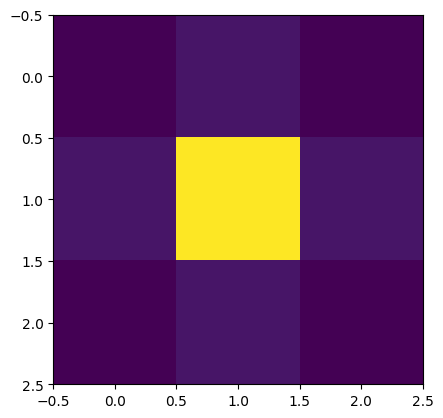

In [15]:
ks = np.linspace(-0.2,0.2,3)
kxs, kys = np.meshgrid(ks,ks)
kincs = np.vstack([kxs.flatten(),kys.flatten()]).T
amps = np.exp((-kxs**2-kys**2)/0.12**2)
plt.imshow(amps)

In [16]:
# obj = rcwa([eps,None,eps], [thickness,0,thickness], [1,1,2], gap_layer_indices=[1], twist=0, N=0, M=ind, verbose=0)
obj = rcwa([np.ones([100,100])], [0], [1], twist=0, N=0, M=ind, verbose=0)
# kincs = np.array([[0.14,0.14]])
# amps = [1.]
tmp = SummedRCWA(obj, freq, kincs, amps)
tmp.total_RT()
fields = tmp.get_field()
ex,ey,ez,hx,hy,hz = fields

te,tm [-0.2  0.2  0. ] [0.19183326 0.19183326 0.08      ]
pte,ptm -0.20000000000000004 0.19183326093250883
te,tm [-0.2  0.   0. ] [0.         0.19595918 0.04      ]
pte,ptm -0.2 0.0
te,tm [-0.2 -0.2  0. ] [-0.19183326  0.19183326  0.08      ]
pte,ptm -0.20000000000000004 -0.19183326093250883
te,tm [ 0.   0.2 -0. ] [0.19595918 0.         0.04      ]
pte,ptm 0.0 0.19595917942265426
te,tm [0. 0. 0.] [0. 0. 0.]
pte,ptm 0.0 0.0
te,tm [ 0.  -0.2  0. ] [-0.19595918  0.          0.04      ]
pte,ptm 0.0 -0.19595917942265426
te,tm [ 0.2  0.2 -0. ] [ 0.19183326 -0.19183326  0.08      ]
pte,ptm 0.20000000000000004 0.19183326093250883
te,tm [0.2 0.  0. ] [ 0.         -0.19595918  0.04      ]
pte,ptm 0.2 0.0
te,tm [ 0.2 -0.2  0. ] [-0.19183326 -0.19183326  0.08      ]
pte,ptm 0.20000000000000004 -0.19183326093250883
te,tm [-0.2  0.2  0. ] [0.19183326 0.19183326 0.08      ]
pte,ptm -0.20000000000000004 0.19183326093250883
te,tm [-0.2  0.   0. ] [0.         0.19595918 0.04      ]
pte,ptm -0.2 0.0
te,t

0it [00:00, ?it/s]

9it [00:00, 841.44it/s]


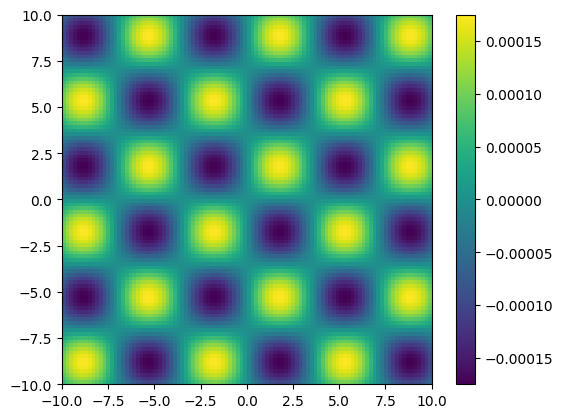

In [14]:
# plt.imshow(ey.real,extent=[tmp.x_min,tmp.x_max,tmp.y_min,tmp.y_max])
plt.imshow(np.real(ey),extent=[tmp.x_min,tmp.x_max,tmp.y_min,tmp.y_max])
# plt.imshow(np.real(ex),extent=[tmp.x_min,tmp.x_max,tmp.y_min,tmp.y_max])
# plt.imshow(np.abs(ex)**2+np.abs(ey)**2,extent=[tmp.x_min,tmp.x_max,tmp.y_min,tmp.y_max])
plt.colorbar()

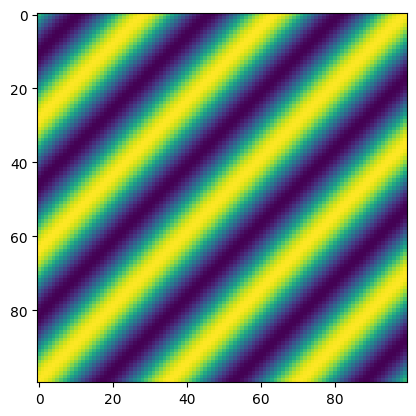

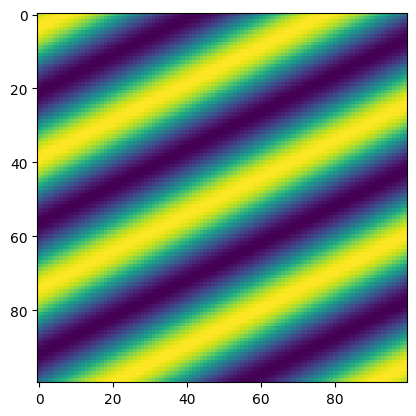

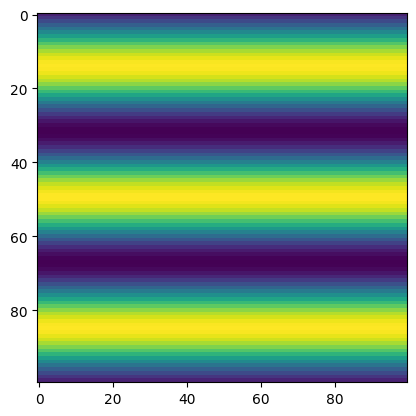

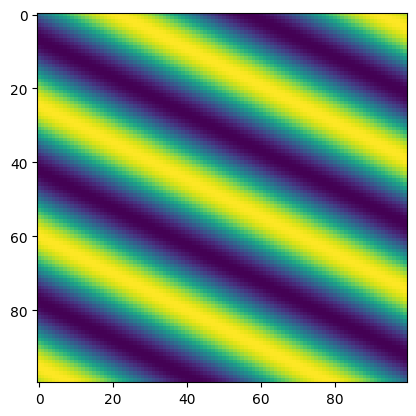

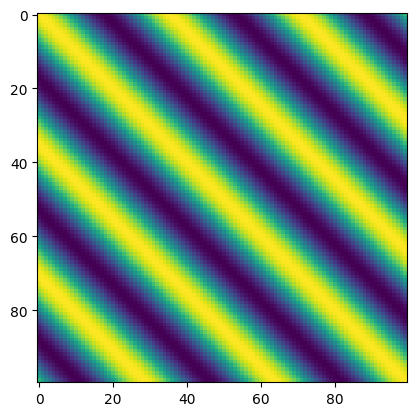

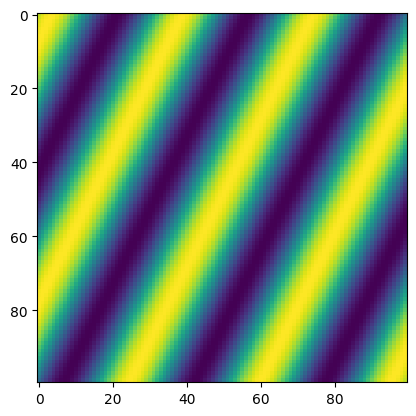

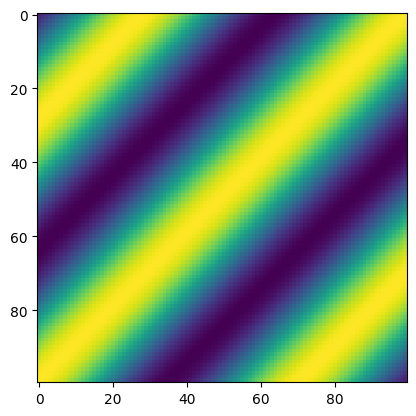

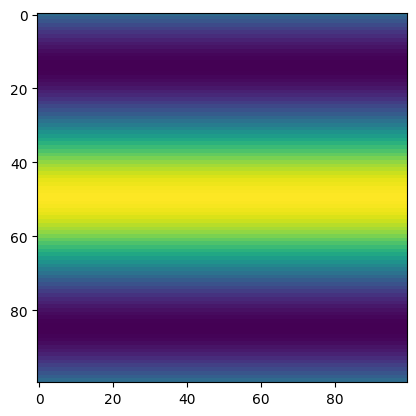

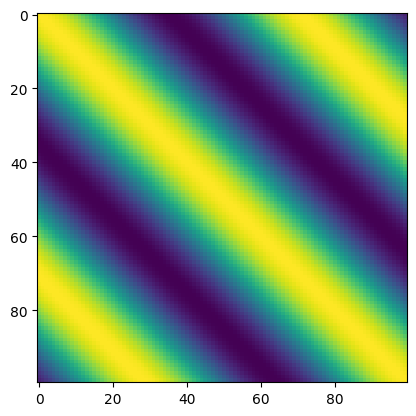

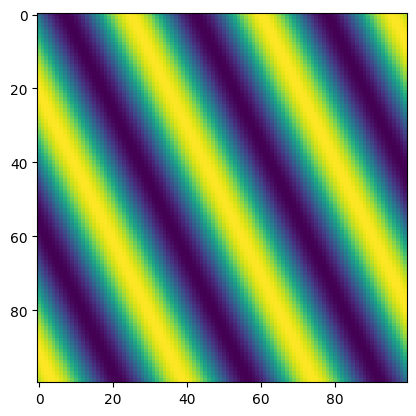

In [44]:
for field in (tmp.real_space_bases[:10]):
    # plt.imshow(field[0].real)
    plt.imshow(field[1].real)
    # plt.imshow(field[2].real)
    plt.show()

In [14]:
def field_fourier_to_real(coefs, real_space_bases): ### 
    '''
    coefs: nk,nG
    real_space_bases: [nG,nX,nY]
    '''
    return np.tensordot(coefs,real_space_bases,axes=([-1],[0]))

In [16]:
field_fourier_to_real(np.ones([2,3]),np.ones([3,100,100])).shape

(2, 100, 100)

In [30]:
np.expand_dims(np.ones(3),axis=0).shape

(1, 3)

### convergence first
seems can use ind=3 for num_rep up to 3

In [59]:
num_rep = 3
### keeping a=1, then effectively smaller thickness and higher freq
thickness_new = thickness / num_rep
freqs_new = freqs * num_rep
eps_new = np.tile(eps,(num_rep,1))

try:
    trans = np.load(f'1example4-trans-{num_rep}.pkl',allow_pickle=True)
except Exception as e:
    print(e)
    trans = []
    kxkys = []
    twist = 0*DEG
    for ind in inds:
        NM = (2*ind+1)**2
        NMNM = NM**2
        obj = rcwa([eps_new,None,eps_new], [thickness_new,0,thickness_new], [1,1,2], gap_layer_indices=[1], twist=twist, N=0, M=ind, verbose=0)
        for freq in tqdm(freqs_new):
            obj.set_freq_k(freq, (0, 0))
            (r,t), (reflected,transmitted) = obj.get_RT(0,1)
            trans.append(t)
    trans = np.array(trans).reshape(len(inds),len(freqs))
    trans.dump(f'example4-trans-{num_rep}.pkl')

[Errno 2] No such file or directory: '1example4-trans-3.pkl'


100%|██████████| 101/101 [00:00<00:00, 368.43it/s]


Text(0.5, 1.0, '3')

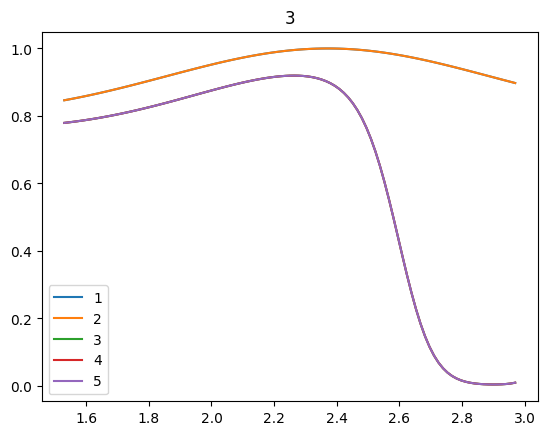

In [60]:
plt.plot(freqs_new,trans.T)
plt.legend(inds)
plt.title(f'{num_rep}')

# get band structure

In [134]:
def perturb(eps,amp=0.3):
    delta = amp*np.sin(np.linspace(0,np.pi*2,len(eps))).reshape(-1,1)
    eps = (1+delta) * eps
    return eps
def get_band(num_rep=1,ind=3,mod_func=None,show=True):
    ### keeping a=1, then effectively smaller thickness and higher freq
    thickness_new = thickness / num_rep
    freqs_new = freqs * num_rep
    eps_new = np.tile(eps,(num_rep,1))
    if mod_func is not None:
        eps_new = mod_func(eps_new)
    try:
        trans = np.load(f'1example4-trans-{num_rep}.pkl',allow_pickle=True)
    except Exception as e:
        print(e)
        trans = []
        kxkys = []
        twist = 0*DEG
        NM = (2*ind+1)**2
        NMNM = NM**2
        obj = rcwa([eps_new,None,eps_new], [thickness_new,0,thickness_new], [1,1,2], gap_layer_indices=[1], twist=twist, N=0, M=ind, verbose=0)
        for freq in tqdm(freqs_new):
            for theta in thetas:
                # obj.set_freq_k(freq, (theta, 0*DEG))
                obj.set_freq_k(freq, (theta, 90*DEG))
                (r,t), (reflected,transmitted) = obj.get_RT(0,1)
                trans.append(t)
        trans = np.array(trans).reshape(len(freqs),len(thetas))
        trans.dump(f'example4-trans-{num_rep}.pkl')
    if show:
        plt.imshow(trans,extent=[thetas[0]/DEG,thetas[-1]/DEG,freqs[0],freqs[-1]],aspect='auto',origin='lower')
        plt.colorbar()
    return trans

[Errno 2] No such file or directory: '1example4-trans-1.pkl'


100%|██████████| 101/101 [00:14<00:00,  6.85it/s]


Text(0.5, 1.0, 'h_period=$\\infty$')

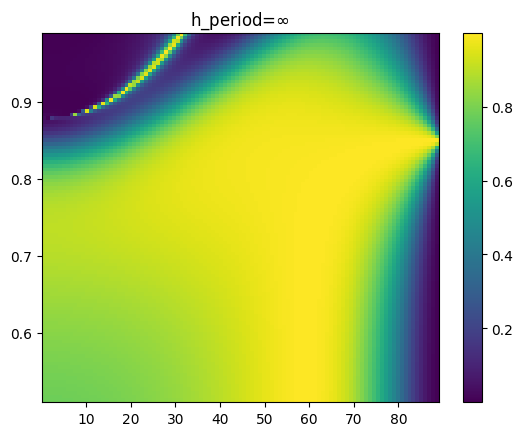

In [130]:
band = get_band()
plt.title(r'h_period=$\infty$')

[Errno 2] No such file or directory: '1example4-trans-2.pkl'


100%|██████████| 101/101 [00:14<00:00,  6.96it/s]


Text(0.5, 1.0, 'h_period=2a')

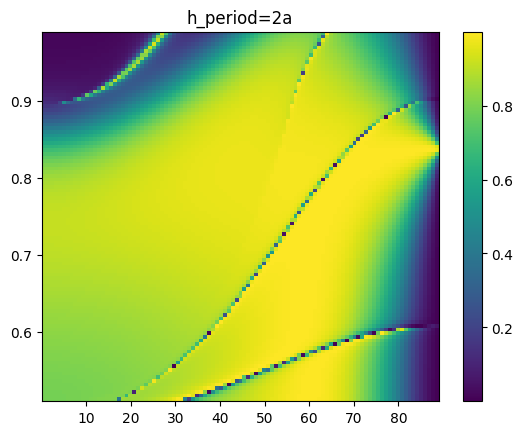

In [131]:
band = get_band(num_rep=2, mod_func=perturb)
plt.title('h_period=2a')

[Errno 2] No such file or directory: '1example4-trans-3.pkl'


100%|██████████| 101/101 [00:14<00:00,  7.00it/s]


Text(0.5, 1.0, 'h_period=3a')

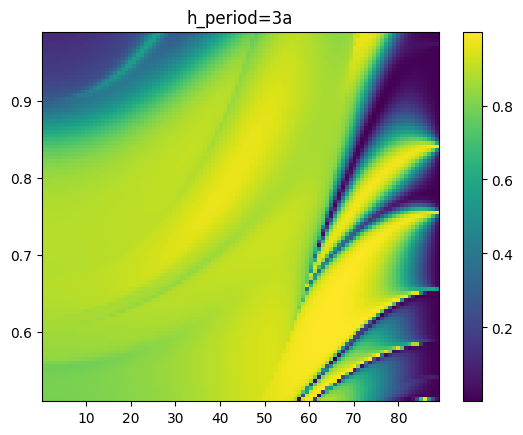

In [132]:
band = get_band(num_rep=3, mod_func=perturb)
plt.title('h_period=3a')

[Errno 2] No such file or directory: '1example4-trans-4.pkl'


100%|██████████| 101/101 [00:31<00:00,  3.21it/s]


Text(0.5, 1.0, 'h_period=4a')

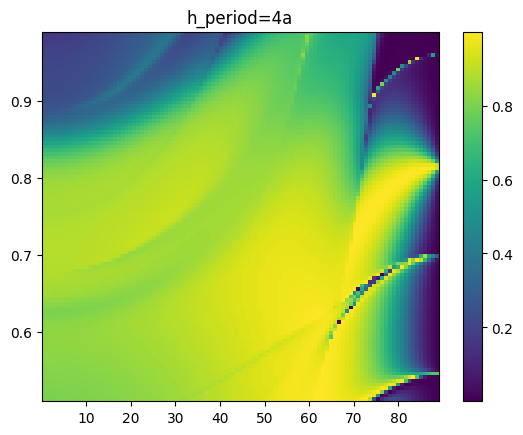

In [133]:
band = get_band(num_rep=4, mod_func=perturb, ind=5)
plt.title('h_period=4a')

[Errno 2] No such file or directory: '1example4-trans-5.pkl'


100%|██████████| 101/101 [01:15<00:00,  1.35it/s]


Text(0.5, 1.0, 'h_period=5a')

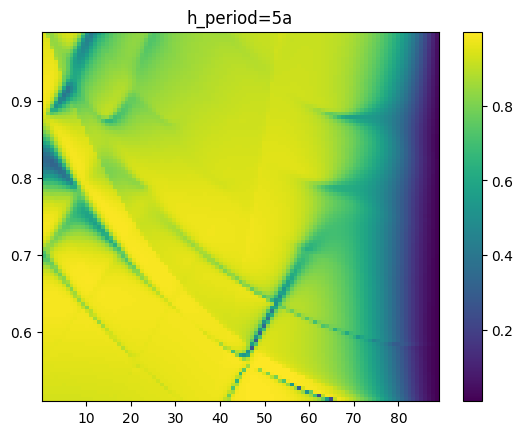

In [137]:
band = get_band(num_rep=5, mod_func=perturb, ind=9)
plt.title('h_period=5a')

[Errno 2] No such file or directory: '1example4-trans-7.pkl'


100%|██████████| 101/101 [03:27<00:00,  2.06s/it]


Text(0.5, 1.0, 'h_period=7a')

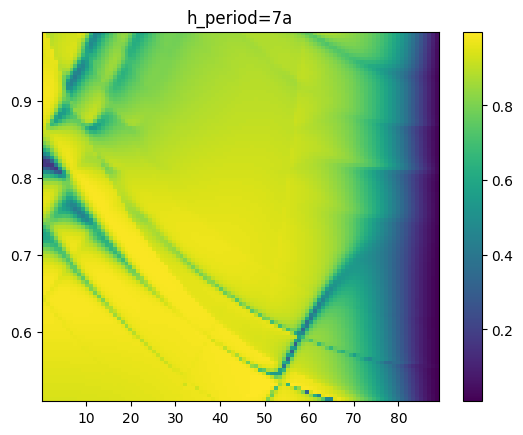

In [150]:
band = get_band(num_rep=7, mod_func=perturb, ind=14)
plt.title('h_period=7a')